In [1]:
import pandas as pd
import numpy as np
import math
import geopandas as gpd
import matplotlib.pyplot as plt
from scipy.integrate import quad
from scipy.optimize import minimize
import sympy as sp
from IPython.display import display, Math, Latex
from shapely.geometry import shape
from shapely.wkt import loads
# import contextily as cx
import seaborn as sns
import mapclassify
from matplotlib.colors import ListedColormap

In [2]:
save_figures = True
folder = 'plots'

In [3]:
data_quantiles_no_insurance = pd.read_csv('results/data_quantiles_no_insurance.csv')
data_quantiles_no_insurance.set_index(data_quantiles_no_insurance.columns[0], inplace=True)
data_bg_no_insurance = pd.read_csv('results/bg_no_insurance.csv')
data_bg_no_insurance['geometry'] = data_bg_no_insurance['geometry'].apply(loads)
bg_no_insurance = gpd.GeoDataFrame(data_bg_no_insurance, geometry="geometry", crs='EPSG:4326')

data_quantiles_base_insurance = pd.read_csv('results/data_quantiles_uptake55_insurance.csv')
data_quantiles_base_insurance.set_index(data_quantiles_base_insurance.columns[0], inplace=True)
data_bg_base_insurance = pd.read_csv('results/bg_uptake55_insurance.csv')
data_bg_base_insurance['geometry'] = data_bg_base_insurance['geometry'].apply(loads)
bg_base_insurance = gpd.GeoDataFrame(data_bg_base_insurance, geometry="geometry", crs='EPSG:4326')

data_bg_lab_not_opt = pd.read_csv('results/bg_no_insurance_labda_not_opt.csv')
data_quantiles_lab_not_opt = pd.read_csv('results/data_quantiles_no_insurance_labda_not_opt.csv')
data_quantiles_lab_not_opt.set_index(data_quantiles_lab_not_opt.columns[0], inplace=True)
data_bg_lab_not_opt['geometry'] = data_bg_lab_not_opt['geometry'].apply(loads)
bg_lab_not_opt = gpd.GeoDataFrame(data_bg_lab_not_opt, geometry="geometry", crs='EPSG:4326')

In [4]:
diff_v = '_const_v'
data_quantiles_const_v = pd.read_csv(f'results/data_quantiles_no_insurance{diff_v}.csv')
data_quantiles_const_v.set_index(data_quantiles_const_v.columns[0], inplace=True)

data_bg_const_v = pd.read_csv(f'results/bg_no_insurance{diff_v}.csv')
data_bg_const_v['geometry'] = data_bg_const_v['geometry'].apply(loads)
bg_const_v = gpd.GeoDataFrame(data_bg_const_v, geometry="geometry", crs='EPSG:4326')

In [5]:
variant = '_eta=2'
data_bg_eta_2 = pd.read_csv(f'results/bg_no_insurance{variant}.csv')
data_quantiles_eta_2 = pd.read_csv(f'results/data_quantiles_no_insurance{variant}.csv')
data_quantiles_eta_2.set_index(data_quantiles_eta_2.columns[0], inplace=True)
data_bg_eta_2['geometry'] = data_bg_eta_2['geometry'].apply(loads)
bg_eta_2 = gpd.GeoDataFrame(data_bg_eta_2, geometry="geometry", crs='EPSG:4326')

In [6]:
oth_damage = '_25_damage'
data_bg_25 = pd.read_csv(f'results/bg_no_insurance{oth_damage}.csv')
data_quantiles_25 = pd.read_csv(f'results/data_quantiles_no_insurance{oth_damage}.csv')
data_quantiles_25.set_index(data_quantiles_25.columns[0], inplace=True)
data_bg_25['geometry'] = data_bg_25['geometry'].apply(loads)
bg_25 = gpd.GeoDataFrame(data_bg_25, geometry="geometry", crs='EPSG:4326')

In [7]:
oth_damage_2 = '_og_damage'
data_bg_og = pd.read_csv(f'results/bg_no_insurance{oth_damage_2}.csv')
data_quantiles_og = pd.read_csv(f'results/data_quantiles_no_insurance{oth_damage_2}.csv')
data_quantiles_og.set_index(data_quantiles_og.columns[0], inplace=True)
data_bg_og['geometry'] = data_bg_og['geometry'].apply(loads)
bg_og = gpd.GeoDataFrame(data_bg_og, geometry="geometry", crs='EPSG:4326')

In [8]:
discount = '_discount1%'
data_quantiles_disc1 = pd.read_csv(f'results/data_quantiles_no_insurance{discount}.csv')
data_quantiles_disc1.set_index(data_quantiles_disc1.columns[0], inplace=True)

data_bg_disc1 = pd.read_csv(f'results/bg_no_insurance{discount}.csv')
data_bg_disc1['geometry'] = data_bg_disc1['geometry'].apply(loads)
bg_disc1 = gpd.GeoDataFrame(data_bg_disc1, geometry="geometry", crs='EPSG:4326')

In [9]:
bg_no_insurance['diff_welfare_loss'] = bg_no_insurance['welfare_loss']-bg_base_insurance['welfare_loss']

In [10]:
# Create an empty DataFrame to calculate percentage changes
columns = ['change_insurance_welfare', 'change_insurance_recovery_t']
percen = pd.DataFrame(columns=columns)

In [11]:
percen['change_insurance_welfare'] = (data_quantiles_base_insurance['welfare_loss'] - data_quantiles_no_insurance['welfare_loss']) / -data_quantiles_no_insurance['welfare_loss']*100
percen['change_insurance_recovery_t'] = (data_quantiles_base_insurance['recovery_time'] - data_quantiles_no_insurance['recovery_time']) / -data_quantiles_no_insurance['recovery_time']*100

In [12]:
(bg_base_insurance['welfare_loss'].sum()-bg_no_insurance['welfare_loss'].sum())/bg_no_insurance['welfare_loss'].sum()*100

-27.029339016661613

In [13]:
percen

change_insurance_welfare  change_insurance_recovery_t
Unnamed: 0                                                             
low_incomes                      26.067939                    37.082635
mid_low_incomes                  27.931281                    38.389560
mid_high_incomes                 27.992459                    39.279164
high_incomes                     28.673670                    39.462143

In [14]:
# Create an empty DataFrame to calculate percentage changes
columns = ['total_premium_payed', 'total_claim']
premium_df = pd.DataFrame(columns=columns)

In [15]:
premium_df['total_premium_payed'] = data_quantiles_no_insurance['premium']*10
premium_df['total_claim'] = data_quantiles_no_insurance['damage']*0.45

In [16]:
premium_df

total_premium_payed   total_claim
Unnamed: 0                                         
low_incomes              10930.962720   2897.424965
mid_low_incomes           5012.910410   4418.586159
mid_high_incomes         18309.092052   6571.230047
high_incomes             14066.746402  12971.023262

In [17]:
def round_legend(df, col, k, round_too):
    # get all upper bounds
    upper_bounds = mapclassify.Quantiles(df[col], k=k).bins
    # insert minimal value in front to get all bounds
    bounds = np.insert(upper_bounds, 0, df[col].min())
    rounded_bounds = np.round(bounds / round_too) * round_too
    # format the numerical legend here
    intervals = [f'{rounded_bounds[i]:.0f}-{rounded_bounds[i+1]:.0f}' for i in range(len(bounds)-1)]

    # get all the legend labels
    legend_labels = ax.get_legend().get_texts()
    # replace the legend labels
    return intervals, legend_labels

#### map average damage & v loss ratio

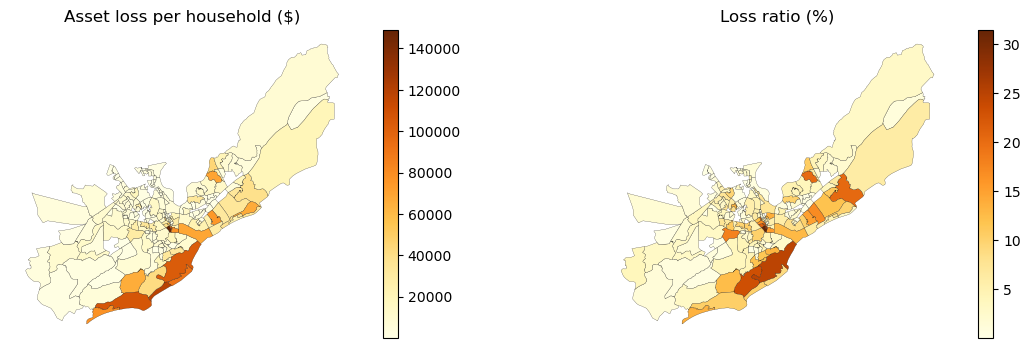

In [18]:
from matplotlib.patches import Patch

f, ax = plt.subplots(1, 2, figsize=(15, 4))
f.subplots_adjust(wspace=0.05)  # Adjust the width space between subplots

bg_no_insurance.plot(ax=ax[0], column='ave_damage', categorical=False, 
                    linewidth=0.15, edgecolor='k', cmap='YlOrBr', legend=True)
bg_no_insurance.plot(ax=ax[0], column='welfare_no_damage',cmap='Greys', categorical=False, linewidth=0.15, edgecolor='k')

bg_no_insurance.plot(ax=ax[1], column='v_percen', categorical=False, 
                    linewidth=0.15, edgecolor='k', cmap='YlOrBr', legend=True)
bg_no_insurance.plot(ax=ax[1], column='welfare_no_damage',cmap='Greys', categorical=False, linewidth=0.15, edgecolor='k')

ax[0].set_title('Asset loss per household ($)')
ax[1].set_title('Loss ratio (%)')

for axis in ax:
    axis.set_aspect(1.2) 
    
ax[0].axis('off')
ax[1].axis('off')

if save_figures == True:
    f.savefig(f'{folder}/maps, extreme event, asset loss and loss ratio.jpg', dpi=1000, bbox_inches='tight')

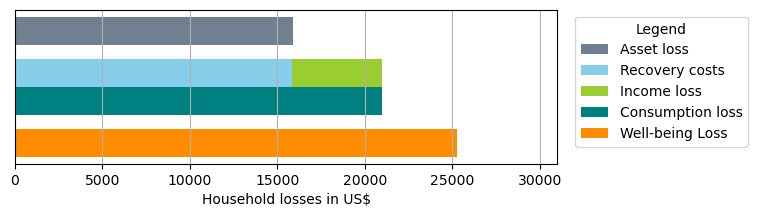

In [19]:
sum_data = pd.DataFrame(bg_no_insurance[['ave_damage', 'welfare_loss','recovery_costs', 'income_loss', 'consump_loss']].mean()).T
# Define the colors
colors = ['slategray', 'teal', 'darkorange']
color = ['skyblue', 'yellowgreen']
custom_cmap = ListedColormap(color)
bar_width = 0.1

# Plot the summed data
ax = sum_data['ave_damage'].plot(kind='barh', figsize=[7, 2],stacked=False, position=0.5, color=colors[0], width=bar_width)#, legend=True)
sum_data[['recovery_costs', 'income_loss']].plot(kind="barh", ax=ax, stacked=True, position=2, cmap=custom_cmap, width=bar_width)#, legend=True)
sum_data['consump_loss'].plot(kind="barh", ax=ax, stacked=False, position=3, color=colors[1], width=bar_width)#, legend=True)
sum_data['welfare_loss'].plot(kind="barh", ax=ax, stacked=False, position=4.5, color=colors[2], width=bar_width)#, legend=True)

ax.set_xlabel('Household losses in US$')
# ax.set_title('Average household losses, extreme event')
plt.axis('tight')
ax.grid(True)
ax.set_xlim(0, 31000)
ax.set_yticks([])

# Place the legend outside of the plot
ax.legend(loc='upper left', bbox_to_anchor=(1.02, 1), title='Legend', labels=['Asset loss','Recovery costs','Income loss', 'Consumption loss','Well-being Loss'])

if save_figures == True:
    plt.savefig(f'{folder}/bar plot, extreme event, of average household losses.jpg', dpi=500, bbox_inches='tight')

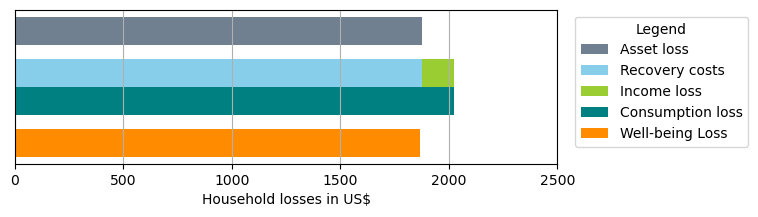

In [20]:
sum_data = pd.DataFrame(bg_og[['ave_damage', 'welfare_loss','recovery_costs', 'income_loss', 'consump_loss']].mean()).T

colors = ['slategray', 'teal', 'darkorange']
color = ['skyblue', 'yellowgreen']
custom_cmap = ListedColormap(color)
bar_width = 0.1

ax = sum_data['ave_damage'].plot(kind='barh', figsize=[7, 2],stacked=False, position=0.5, color=colors[0], width=bar_width)#, legend=True)
sum_data[['recovery_costs', 'income_loss']].plot(kind="barh", ax=ax, stacked=True, position=2, cmap=custom_cmap, width=bar_width)#, legend=True)
sum_data['consump_loss'].plot(kind="barh", ax=ax, stacked=False, position=3, color=colors[1], width=bar_width)#, legend=True)
sum_data['welfare_loss'].plot(kind="barh", ax=ax, stacked=False, position=4.5, color=colors[2], width=bar_width)#, legend=True)

ax.set_xlabel('Household losses in US$')
# ax.set_title('Average household losses, actual event')
plt.axis('tight')
ax.grid(True)
ax.set_xlim(0, 2500)
ax.set_yticks([])

ax.legend(loc='upper left', bbox_to_anchor=(1.02, 1), title='Legend', labels=['Asset loss','Recovery costs','Income loss', 'Consumption loss','Well-being Loss'])

if save_figures == True:
    plt.savefig(f'{folder}/bar plot, actual event, of average household losses.jpg', dpi=500, bbox_inches='tight')

In [21]:
sum_data['ave_damage']

0    1874.682947
Name: ave_damage, dtype: float64

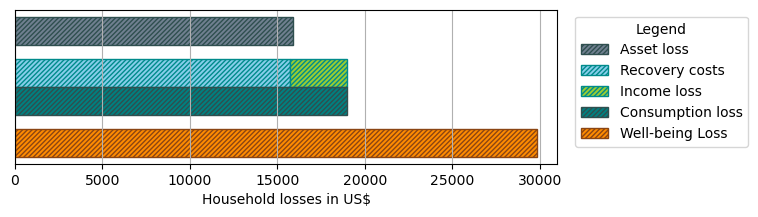

In [22]:
sum_data = pd.DataFrame(bg_const_v[['ave_damage', 'welfare_loss','recovery_costs', 'income_loss', 'consump_loss']].mean()).T
# Define the colors
colors = ['slategray', 'teal', 'darkorange']
color = ['skyblue', 'yellowgreen']
custom_cmap = ListedColormap(color)
bar_width = 0.1

# Plot the summed data
ax = sum_data['ave_damage'].plot(hatch='///////',edgecolor='darkslategrey',kind='barh', figsize=[7, 2],stacked=False, position=0.5, color=colors[0], width=bar_width)#, legend=True)
sum_data[['recovery_costs', 'income_loss']].plot(hatch='///////',edgecolor='darkcyan',kind="barh", ax=ax, stacked=True, position=2, cmap=custom_cmap, width=bar_width)#, legend=True)
sum_data['consump_loss'].plot(hatch='///////',edgecolor='darkslategrey',kind="barh", ax=ax, stacked=False, position=3, color=colors[1], width=bar_width)#, legend=True)
sum_data['welfare_loss'].plot(hatch='///////',edgecolor='saddlebrown',kind="barh", ax=ax, stacked=False, position=4.5, color=colors[2], width=bar_width)#, legend=True)

ax.set_xlabel('Household losses in US$')
# ax.set_title('Average household losses, control event')
plt.axis('tight')
ax.grid(True)
ax.set_xlim(0, 31000)
ax.set_yticks([])

ax.legend(loc='upper left', bbox_to_anchor=(1.02, 1), title='Legend', labels=['Asset loss','Recovery costs','Income loss', 'Consumption loss','Well-being Loss'])

# Save the plot if required
if save_figures:
    plt.savefig(f'{folder}/bar plot, control event, of average household losses.jpg', dpi=500, bbox_inches='tight')

#### map of income?

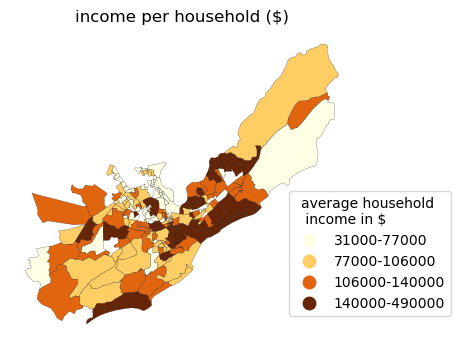

In [23]:
f, ax = plt.subplots(figsize=(10, 4))
bg_no_insurance.plot(ax=ax, column='ave_i_0', categorical=False, 
                    linewidth=0.15, edgecolor='k', cmap='YlOrBr', legend=True, scheme='QUANTILES', k=4)

ax.set_title('income per household ($)')

ax.set_aspect(1.2) 
ax.axis('off')
legend = ax.get_legend()
legend.set_bbox_to_anchor((1.3, 0.5))

legend.set_title('average household \n income in $')

leg = round_legend(bg_no_insurance, 'ave_i_0',4, 1000)
for interval, legend_label in zip(leg[0], leg[1]):
    legend_label.set_text(interval)

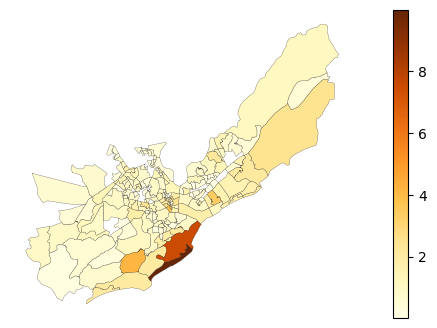

In [24]:
f, ax = plt.subplots(figsize=(10, 4))
bg_no_insurance.plot(ax=ax, column='recovery_time', categorical=False, 
                    linewidth=0.15, edgecolor='k', cmap='YlOrBr', legend=True)
# ax.set_title('recovery time in years')
ax.set_aspect(1.2) 
ax.axis('off')

if save_figures == True:
    f.savefig(f'{folder}/map, extreme event recovery time in years.jpg', dpi=1000, bbox_inches='tight')

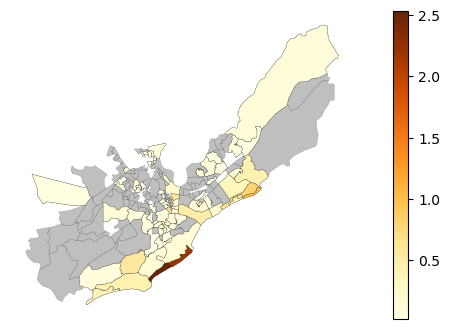

In [25]:
f, ax = plt.subplots(figsize=(10, 4))

bg_no_insurance.plot(ax=ax,color='grey', categorical=False, linewidth=0.15, edgecolor='k',alpha=0.5)
bg_og.plot(ax=ax, column='recovery_time', categorical=False, 
                    linewidth=0.15, edgecolor='k', cmap='YlOrBr', legend=True)
# ax.set_title('recovery time in years')
ax.set_aspect(1.2) 
ax.axis('off')

if save_figures == True:
    f.savefig(f'{folder}/map, actual event recovery time in years.jpg', dpi=1000, bbox_inches='tight')

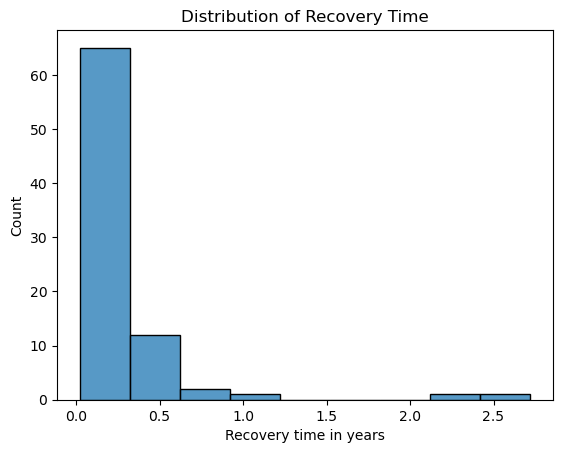

In [26]:
fig = sns.histplot(data=bg_og['recovery_time'], binwidth=0.3)
plt.xlabel('Recovery time in years')
plt.title('Distribution of Recovery Time')

if save_figures == True:
    plt.savefig(f'{folder}/histogram, actual event, recovery time.jpg', dpi=300, bbox_inches='tight')

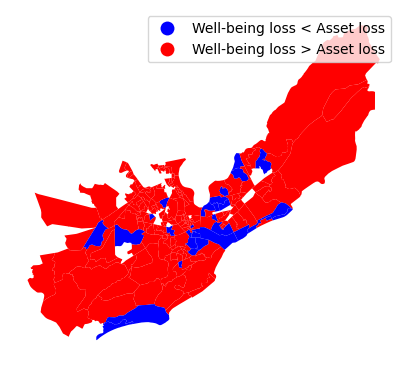

In [27]:
bg_no_insurance['color'] = 'blue'  # Default color
bg_no_insurance.loc[bg_no_insurance['welfare_loss'] > bg_no_insurance['ave_damage'], 'color'] = 'red'

colors = ['blue', 'red']
cmap = ListedColormap(colors)

legend_labels = {'blue': 'Well-being loss < Asset loss',
                 'red': 'Well-being loss > Asset loss'}

# Plot the GeoDataFrame using the custom colormap and labels
fig, ax = plt.subplots(figsize=(5, 5))
bg_no_insurance.plot(ax=ax, column='color', legend=True, cmap=cmap)
legend = ax.get_legend()
for key, label in legend_labels.items():
    legend.get_texts()[colors.index(key)].set_text(label)
ax.set_aspect(1.2)
ax.axis('off')
plt.show()

#### map average asset loss &  average welfare loss

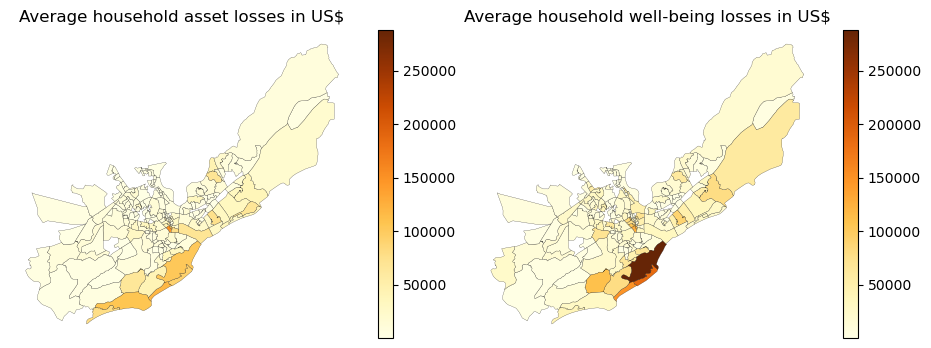

In [28]:
min_value = min(bg_no_insurance['ave_damage'].min(), bg_no_insurance['welfare_loss'].min())
max_value = max(bg_no_insurance['ave_damage'].max(), bg_no_insurance['welfare_loss'].max())

f, ax = plt.subplots(1, 2, figsize=(12, 4))
f.subplots_adjust(wspace=0.001)  # Adjust the width space between subplots

bg_no_insurance.plot(ax=ax[0], column='ave_damage', categorical=False, 
                    linewidth=0.15, edgecolor='k', cmap='YlOrBr', legend=True, vmin=min_value, vmax=max_value)
bg_no_insurance.plot(ax=ax[0], column='welfare_no_damage',cmap='Greys', categorical=False, linewidth=0.15, edgecolor='k')
bg_no_insurance.plot(ax=ax[1], column='welfare_loss', categorical=False, 
                    linewidth=0.15, edgecolor='k', cmap='YlOrBr', legend=True, vmin=min_value, vmax=max_value)
bg_no_insurance.plot(ax=ax[1], column='welfare_no_damage',cmap='Greys', categorical=False, linewidth=0.15, edgecolor='k')

ax[0].set_title('Average household asset losses in US$')
ax[1].set_title('Average household well-being losses in US$')

for axis in ax:
    axis.set_aspect(1.2) 
    
ax[0].axis('off')
ax[1].axis('off')

if save_figures == True:
    f.savefig(f'{folder}/maps, extreme event, asset loss and welfare loss no insurance.jpg', dpi=600, bbox_inches='tight')

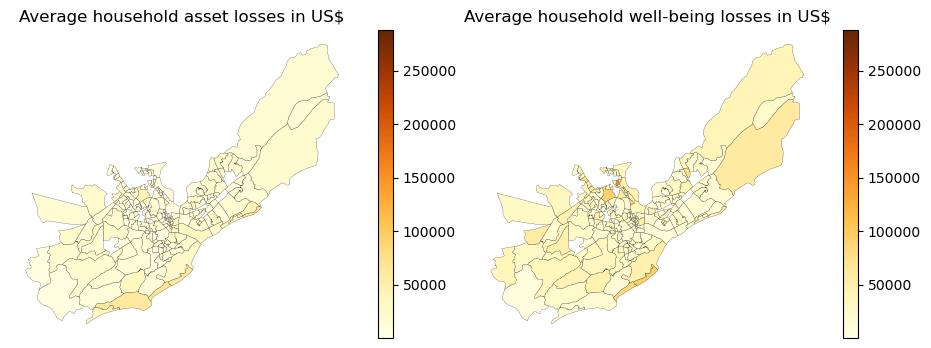

In [29]:
# min_value = min(bg_const_v['ave_damage'].min(), bg_const_v['welfare_loss'].min())
# max_value = max(bg_const_v['ave_damage'].max(), bg_const_v['welfare_loss'].max())

f, ax = plt.subplots(1, 2, figsize=(12, 4))
f.subplots_adjust(wspace=0.001)  # Adjust the width space between subplots

bg_const_v.plot(ax=ax[0], column='ave_damage', categorical=False, 
                    linewidth=0.15, edgecolor='k', cmap='YlOrBr', legend=True, vmin=min_value, vmax=max_value)
bg_const_v.plot(ax=ax[0], column='welfare_no_damage',cmap='Greys', categorical=False, linewidth=0.15, edgecolor='k')
bg_const_v.plot(ax=ax[1], column='welfare_loss', categorical=False, 
                    linewidth=0.15, edgecolor='k', cmap='YlOrBr', legend=True, vmin=min_value, vmax=max_value)
bg_const_v.plot(ax=ax[1], column='welfare_no_damage',cmap='Greys', categorical=False, linewidth=0.15, edgecolor='k')


ax[0].set_title('Average household asset losses in US$')
ax[1].set_title('Average household well-being losses in US$')

for axis in ax:
    axis.set_aspect(1.2) 
    
ax[0].axis('off')
ax[1].axis('off')

if save_figures == True:
    f.savefig(f'{folder}/maps, control event, asset loss and welfare loss no insurance.jpg', dpi=600, bbox_inches='tight')

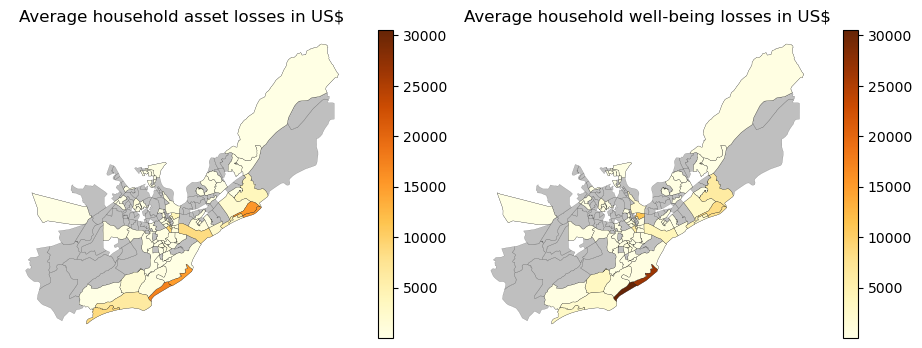

In [30]:
min_value = min(bg_og['ave_damage'].min(), bg_og['welfare_loss'].min())
max_value = max(bg_og['ave_damage'].max(), bg_og['welfare_loss'].max())

f, ax = plt.subplots(1, 2, figsize=(12, 4))
f.subplots_adjust(wspace=0.001)  # Adjust the width space between subplots

bg_no_insurance.plot(ax=ax[0],color='grey', categorical=False, linewidth=0.15, edgecolor='k',alpha=0.5)
bg_og.plot(ax=ax[0], column='ave_damage', categorical=False, 
                    linewidth=0.15, edgecolor='k', cmap='YlOrBr', legend=True, vmin=min_value, vmax=max_value)
bg_no_insurance.plot(ax=ax[1],color='grey', categorical=False, linewidth=0.15, edgecolor='k',alpha=0.5)
bg_og.plot(ax=ax[1], column='welfare_loss', categorical=False, 
                    linewidth=0.15, edgecolor='k', cmap='YlOrBr', legend=True, vmin=min_value, vmax=max_value)

ax[0].set_title('Average household asset losses in US$')
ax[1].set_title('Average household well-being losses in US$')

for axis in ax:
    axis.set_aspect(1.2) 
    
ax[0].axis('off')
ax[1].axis('off')

if save_figures == True:
    f.savefig(f'{folder}/maps, actual event, asset loss and welfare loss no insurance.jpg', dpi=600, bbox_inches='tight')

#### map building damage (??) & recovery time in years

(-80.3392635, -79.4784145, 32.543873600000005, 33.1856224)

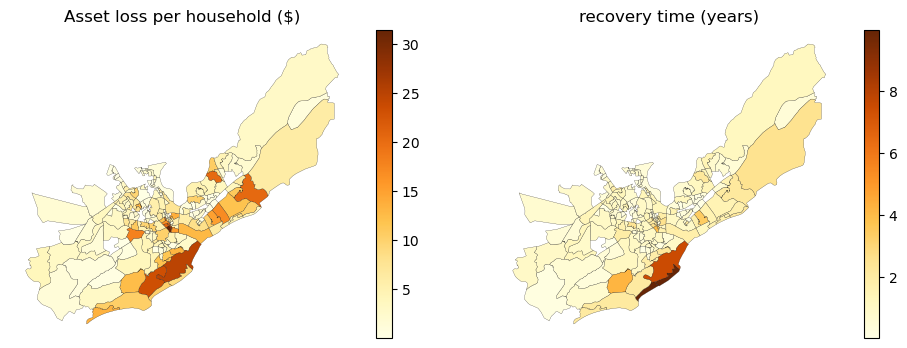

In [31]:
f, ax = plt.subplots(1, 2, figsize=(12, 4))
f.subplots_adjust(wspace=0.1)  # Adjust the width space between subplots

bg_no_insurance.plot(ax=ax[0], column='v_percen', categorical=False, 
                    linewidth=0.15, edgecolor='k', cmap='YlOrBr', legend=True)
bg_no_insurance.plot(ax=ax[0], column='welfare_no_damage',cmap='Greys', categorical=False, linewidth=0.15, edgecolor='k')
bg_no_insurance.plot(ax=ax[1], column='recovery_time', categorical=False, 
                    linewidth=0.15, edgecolor='k', cmap='YlOrBr', legend=True)
bg_no_insurance.plot(ax=ax[1], column='welfare_no_damage',cmap='Greys', categorical=False, linewidth=0.15, edgecolor='k')

ax[0].set_title('Asset loss per household ($)')
ax[1].set_title('recovery time (years)')

for axis in ax:
    axis.set_aspect(1.2) 
    
ax[0].axis('off')
ax[1].axis('off')

# if save_figures == True:
#     f.savefig(f'{folder}/maps asset loss and loss ratio.png', dpi=1000, bbox_inches='tight')

#### map welfare loss lambda not optimized & welfare loss lambda optimized

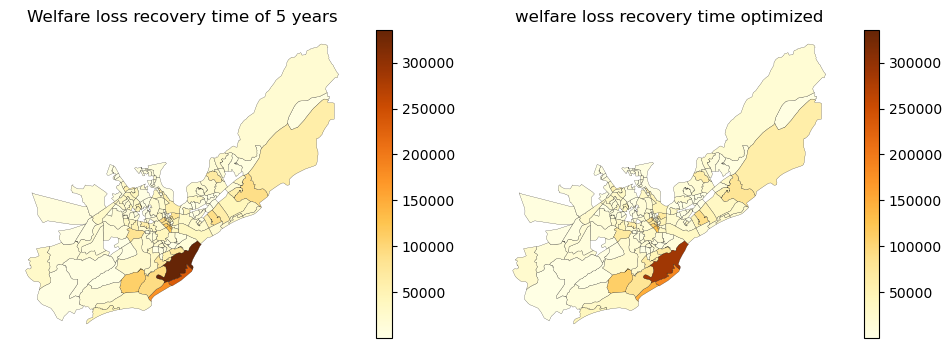

In [32]:
min_value = min(bg_lab_not_opt['welfare_loss'].min(), bg_no_insurance['welfare_loss'].min())
max_value = max(bg_lab_not_opt['welfare_loss'].max(), bg_no_insurance['welfare_loss'].max())

f, ax = plt.subplots(1, 2, figsize=(12, 4))
f.subplots_adjust(wspace=0.1)  # Adjust the width space between subplots

bg_lab_not_opt.plot(ax=ax[0], column='welfare_loss', categorical=False, 
                    linewidth=0.15, edgecolor='k', cmap='YlOrBr', legend=True, vmin=min_value, vmax=max_value)
bg_no_insurance.plot(ax=ax[0], column='welfare_no_damage',cmap='Greys', categorical=False, linewidth=0.15, edgecolor='k')
bg_no_insurance.plot(ax=ax[1], column='welfare_loss', categorical=False, 
                    linewidth=0.15, edgecolor='k', cmap='YlOrBr', legend=True, vmin=min_value, vmax=max_value)
bg_no_insurance.plot(ax=ax[1], column='welfare_no_damage',cmap='Greys', categorical=False, linewidth=0.15, edgecolor='k')

ax[0].set_title('Welfare loss recovery time of 5 years')
ax[1].set_title('welfare loss recovery time optimized')

for axis in ax:
    axis.set_aspect(1.2) 
    
ax[0].axis('off')
ax[1].axis('off')

if save_figures == True:
    f.savefig(f'{folder}/maps, extreme event, sensitivity recovery time.jpg', dpi=1000, bbox_inches='tight')

#### results per income group → damage & welfare loss & income loss

In [33]:
bg_og['owner_households'].sum()

35630

In [34]:
categories = ['Lowest \n incomes', 'Mid-low \n incomes', 'Mid-high \n incomes', 'Highest \n incomes']
colors = ['slategray', 'darkorange', 'yellowgreen']
colors_lab = ['gold', 'darkgreen']

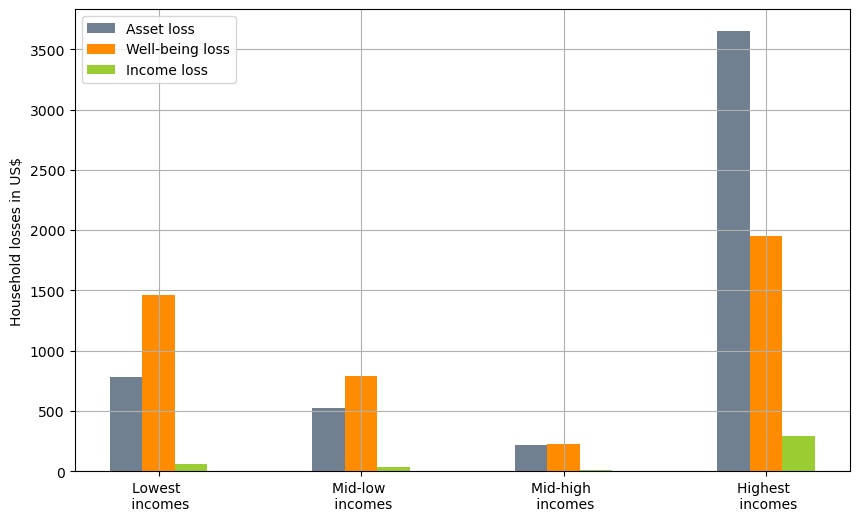

In [35]:
bar_width=0.16
ax = data_quantiles_og['damage'].plot(figsize=[10,6],kind='bar', stacked=False, position=1.5, color=colors[0],width=bar_width)
data_quantiles_og['welfare_loss'].plot(kind="bar", ax=ax, stacked=False, position=0.5, color=colors[1], width=bar_width)
data_quantiles_og['income_loss'].plot(kind="bar", ax=ax, stacked=False, position=-0.5, color=colors[2], width=bar_width)

ax.set_ylabel('Household losses in US$')
ax.set_xlabel('')
# ax.set_title(f'welfare loss, asset loss and income loss per household')
ax.grid(True)
plt.axis('tight')  

plt.xticks(range(len(categories)), categories, rotation=0)
ax.legend(['Asset loss', 'Well-being loss', 'Income loss'])

if save_figures == True:
    plt.savefig(f'{folder}/Quantiles, actual event.jpg',dpi=500, bbox_inches='tight')

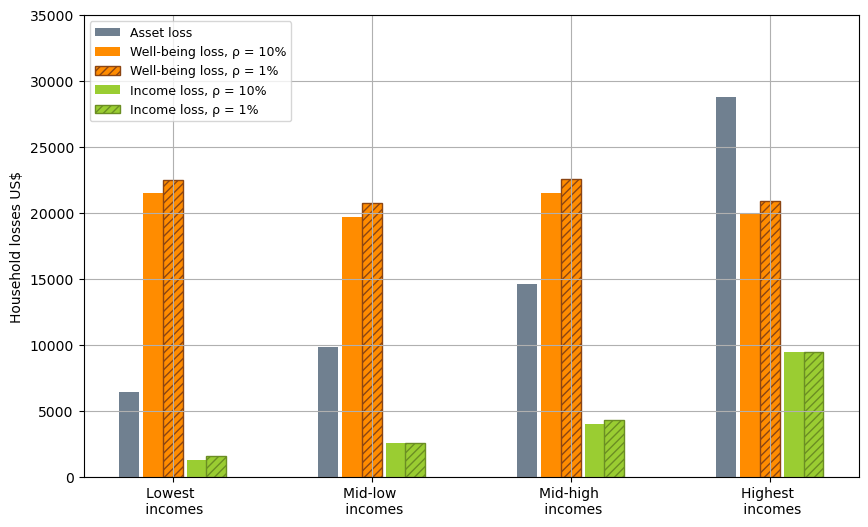

In [36]:
bar_width=0.1
ax = data_quantiles_no_insurance['damage'].plot(figsize=[10,6],kind='bar', stacked=False, position=2.7, color=colors[0],width=bar_width)
data_quantiles_no_insurance['welfare_loss'].plot(kind="bar", ax=ax, stacked=False, position=1.5, color=colors[1], width=bar_width)
data_quantiles_disc1['welfare_loss'].plot(hatch='////',edgecolor='saddlebrown',kind='bar',ax=ax, stacked=False, position=0.5, color=colors[1],width=bar_width)

data_quantiles_no_insurance['income_loss'].plot(kind="bar", ax=ax, stacked=False, position=-0.7, color=colors[2], width=bar_width)
data_quantiles_disc1['income_loss'].plot(hatch='////',edgecolor='olivedrab',kind="bar", ax=ax, stacked=False, position=-1.7, color=colors[2], width=bar_width)

ax.set_ylabel('Household losses US$')
ax.set_xlabel('')
# ax.set_title(f'Losses per household, sensitivity of discount rate (\u03C1)')
ax.grid(True)
plt.axis('tight') 
ax.set_ylim(0, 35000)
plt.xticks(range(len(categories)), categories, rotation=0)

sensi_variant = '\u03C1 = 1%'
ax.legend(bbox_to_anchor=(0, 1), loc='upper left',labels=['Asset loss', 'Well-being loss, \u03C1 = 10%', f'Well-being loss, {sensi_variant}', 'Income loss, \u03C1 = 10%', f'Income loss, {sensi_variant}'], fontsize=9)

if save_figures == True:
    plt.savefig(f'{folder}/Quantiles, extreme event, sensitivity discount rate 1.jpg',dpi=500, bbox_inches='tight')

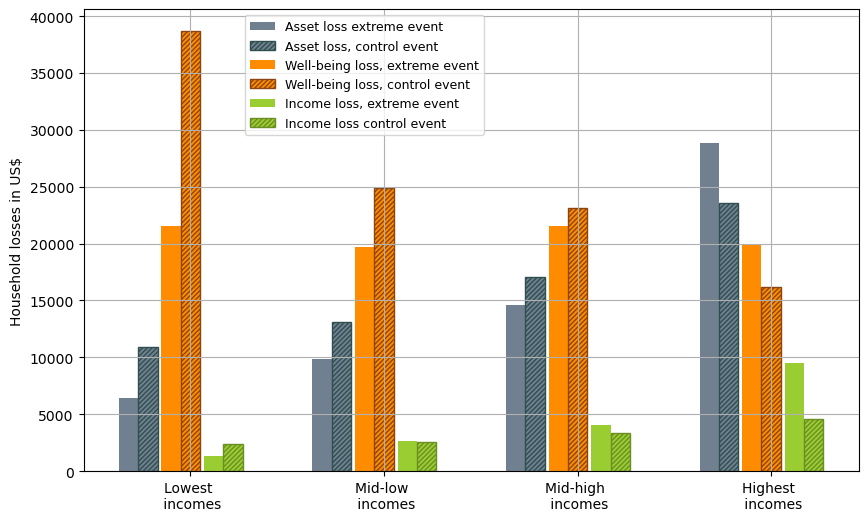

In [37]:
bar_width=0.1
ax = data_quantiles_no_insurance['damage'].plot(figsize=[10,6],kind='bar', stacked=False, position=3.7, color=colors[0],width=bar_width)
data_quantiles_const_v['damage'].plot(hatch='///////',edgecolor='darkslategray',kind="bar", ax=ax, stacked=False, position=2.7, color=colors[0], width=bar_width)

data_quantiles_no_insurance['welfare_loss'].plot(kind="bar", ax=ax, stacked=False, position=1.5, color=colors[1], width=bar_width)
data_quantiles_const_v['welfare_loss'].plot(hatch='///////',edgecolor='saddlebrown',kind='bar',ax=ax, stacked=False, position=0.5, color=colors[1],width=bar_width)

data_quantiles_no_insurance['income_loss'].plot(kind="bar", ax=ax, stacked=False, position=-0.7, color=colors[2], width=bar_width)
data_quantiles_const_v['income_loss'].plot(hatch='///////',edgecolor='olivedrab',kind="bar", ax=ax, stacked=False, position=-1.7, color=colors[2], width=bar_width)

ax.set_ylabel('Household losses in US$')
ax.set_xlabel('')
# ax.set_title(f'Losses per household, extreme event and control event')
ax.grid(True)
plt.axis('tight')  
# ax.set_ylim(0, 35000)
plt.xticks(range(len(categories)), categories, rotation=0)
ax.legend(bbox_to_anchor=(0.2, 1), loc='upper left',labels=['Asset loss extreme event','Asset loss, control event', 'Well-being loss, extreme event', 'Well-being loss, control event', 'Income loss, extreme event', 'Income loss control event'], fontsize=9)

if save_figures == True:
    plt.savefig(f'{folder}/Quantiles, extreme event & control event.jpg',dpi=500, bbox_inches='tight')

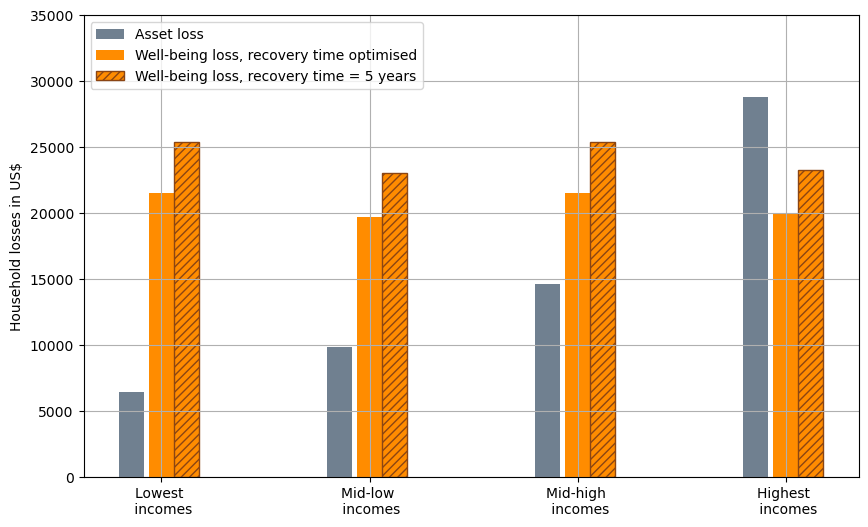

In [38]:
bar_width=0.12
ax = data_quantiles_no_insurance['damage'].plot(figsize=[10,6],kind='bar', stacked=False, position=1.7, color=colors[0],width=bar_width)
data_quantiles_no_insurance['welfare_loss'].plot(kind="bar", ax=ax, stacked=False, position=0.5, color=colors[1], width=bar_width)
data_quantiles_lab_not_opt['welfare_loss'].plot(hatch='////',edgecolor='saddlebrown',kind='bar',ax=ax, stacked=False, position=-0.5, color=colors[1],width=bar_width)

# data_quantiles_no_insurance['income_loss'].plot(kind="bar", ax=ax, stacked=False, position=-0.7, color=colors[2], width=bar_width)
# data_quantiles_lab_not_opt['income_loss'].plot(hatch='////',edgecolor='olivedrab',kind="bar", ax=ax, stacked=False, position=-1.7, color=colors[2], width=bar_width)

ax.set_ylabel('Household losses in US$')
ax.set_xlabel('')
# ax.set_title(f'Losses per household, sensitivity of optimizing recovery time')
ax.grid(True)
plt.axis('tight')  
ax.set_ylim(0, 35000)

plt.xticks(range(len(categories)), categories, rotation=0)
ax.legend(loc='upper left',labels=['Asset loss', 'Well-being loss, recovery time optimised', 'Well-being loss, recovery time = 5 years', 'income loss, recovery time optimized', 'income loss, recovery time = 5 years'])

if save_figures == True:
    plt.savefig(f'{folder}/Quantiles, extreme event, sensitivity recovery_time only welfare.jpg',dpi=500, bbox_inches='tight')

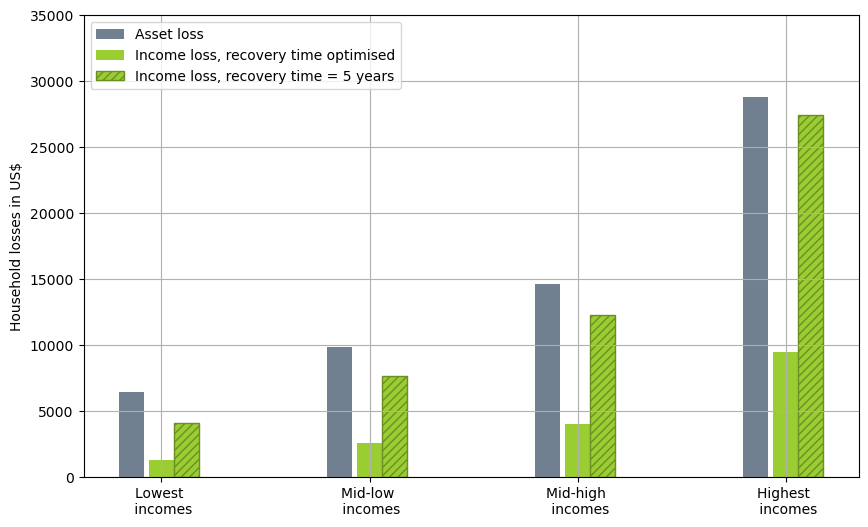

In [39]:
bar_width=0.12
ax = data_quantiles_no_insurance['damage'].plot(figsize=[10,6],kind='bar', stacked=False, position=1.7, color=colors[0],width=bar_width)
data_quantiles_no_insurance['income_loss'].plot(kind="bar", ax=ax, stacked=False, position=0.5, color=colors[2], width=bar_width)
data_quantiles_lab_not_opt['income_loss'].plot(hatch='////',edgecolor='olivedrab',kind='bar',ax=ax, stacked=False, position=-0.5, color=colors[2],width=bar_width)

ax.set_ylabel('Household losses in US$')
ax.set_xlabel('')
# ax.set_title(f'Losses per household, sensitivity of optimizing recovery time')
ax.grid(True)
plt.axis('tight') 
ax.set_ylim(0, 35000)

plt.xticks(range(len(categories)), categories, rotation=0)
ax.legend(loc='upper left',labels=['Asset loss', 'Income loss, recovery time optimised', 'Income loss, recovery time = 5 years', 'income loss, recovery time optimized', 'income loss, recovery time = 5 years'])

if save_figures == True:
    plt.savefig(f'{folder}/Quantiles, extreme event, sensitivity recovery_time only income loss.jpg',dpi=500, bbox_inches='tight')

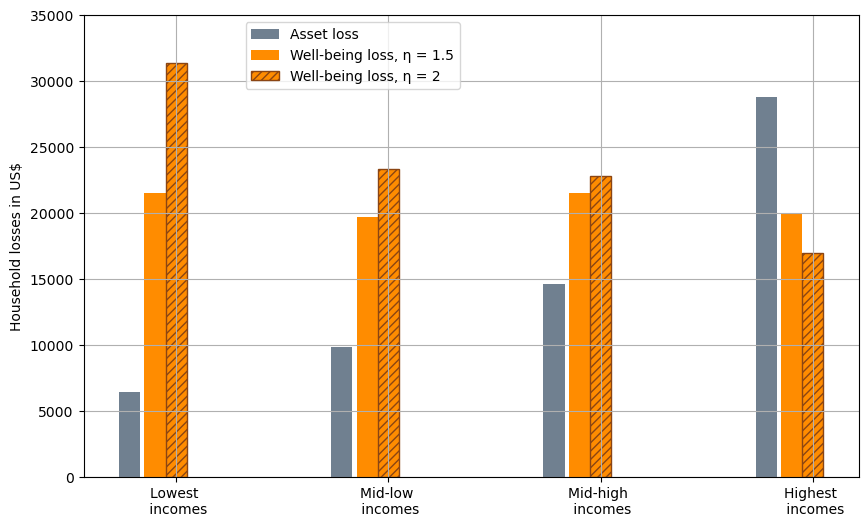

In [40]:
bar_width=0.1
ax = data_quantiles_no_insurance['damage'].plot(figsize=[10,6],kind='bar', stacked=False, position=2.7, color=colors[0],width=bar_width)
data_quantiles_no_insurance['welfare_loss'].plot(kind="bar", ax=ax, stacked=False, position=1.5, color=colors[1], width=bar_width)
data_quantiles_eta_2['welfare_loss'].plot(hatch='////',edgecolor='saddlebrown',kind='bar',ax=ax, stacked=False, position=0.5, color=colors[1],width=bar_width)

# data_quantiles_no_insurance['income_loss'].plot(kind="bar", ax=ax, stacked=False, position=-0.7, color=colors[2], width=bar_width)
# data_quantiles_eta_2['income_loss'].plot(hatch='////',edgecolor='olivedrab',kind="bar", ax=ax, stacked=False, position=-1.7, color=colors[2], width=bar_width)

# Set plot labels and title
ax.set_ylabel('Household losses in US$')
ax.set_xlabel('')
# ax.set_title(f'Losses per household, sensitivity of marginal elasticity of utility (\u03B7)')
ax.grid(True)
plt.axis('tight') 
ax.set_ylim(0, 35000)

plt.xticks(range(len(categories)), categories, rotation=0)
ax.legend(bbox_to_anchor=(0.2, 1), loc='upper left',labels=['Asset loss', 'Well-being loss, \u03B7 = 1.5', 'Well-being loss, \u03B7 = 2', 'Income loss, \u03B7 = 1.5', 'Income loss, \u03B7 = 2'])

if save_figures == True:
    plt.savefig(f'{folder}/Quantiles, extreme event, sensitivity eta=2.jpg',dpi=500, bbox_inches='tight')

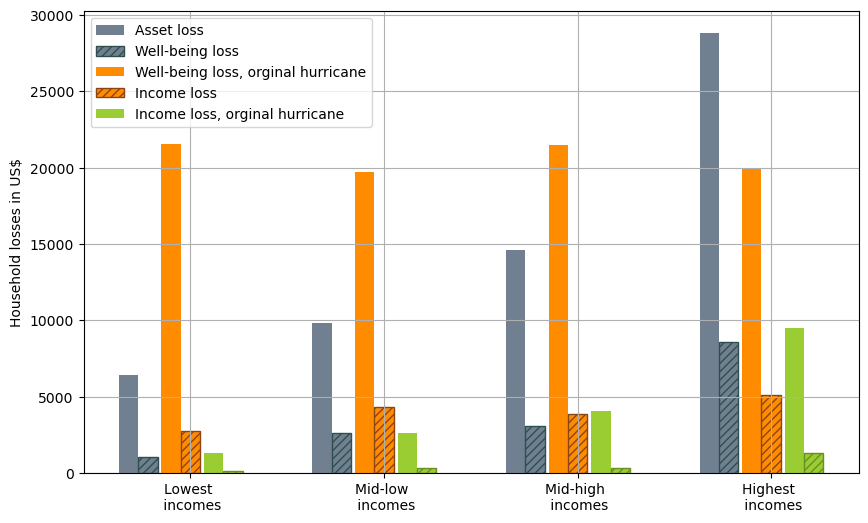

In [41]:
bar_width=0.1
ax = data_quantiles_no_insurance['damage'].plot(figsize=[10,6],kind='bar', stacked=False, position=3.7, color=colors[0],width=bar_width)
data_quantiles_25['damage'].plot(hatch='////',edgecolor='darkslategray',kind="bar", ax=ax, stacked=False, position=2.7, color=colors[0], width=bar_width)

data_quantiles_no_insurance['welfare_loss'].plot(kind="bar", ax=ax, stacked=False, position=1.5, color=colors[1], width=bar_width)
data_quantiles_25['welfare_loss'].plot(hatch='////',edgecolor='saddlebrown',kind='bar',ax=ax, stacked=False, position=0.5, color=colors[1],width=bar_width)

data_quantiles_no_insurance['income_loss'].plot(kind="bar", ax=ax, stacked=False, position=-0.7, color=colors[2], width=bar_width)
data_quantiles_25['income_loss'].plot(hatch='////',edgecolor='olivedrab',kind="bar", ax=ax, stacked=False, position=-1.7, color=colors[2], width=bar_width)

ax.set_ylabel('Household losses in US$')
ax.set_xlabel('')
# ax.set_title(f'Losses per household, sensitivity of asset loss scenario')
ax.grid(True)
plt.axis('tight')  
categories = ['Lowest \n incomes', 'Mid-low \n incomes', 'Mid-high \n incomes', 'Highest \n incomes']
plt.xticks(range(len(categories)), categories, rotation=0)

ax.legend(['Asset loss', 'Well-being loss', 'Well-being loss, orginal hurricane', 'Income loss', 'Income loss, orginal hurricane'])

if save_figures == True:
    plt.savefig(f'{folder}/Quantiles, extreme event, sensitivity input data, asset losses.jpg',dpi=500, bbox_inches='tight')

#### map welfare loss insurance & welfare loss without insurance

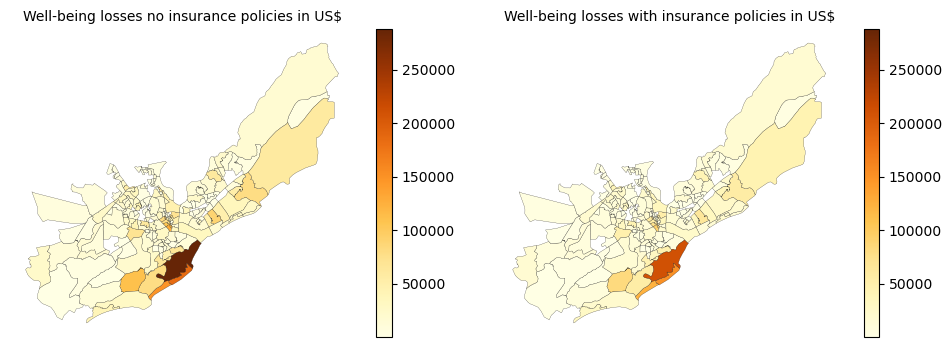

In [42]:
min_value = min(bg_base_insurance['welfare_loss'].min(), bg_no_insurance['welfare_loss'].min())
max_value = max(bg_base_insurance['welfare_loss'].max(), bg_no_insurance['welfare_loss'].max())

f, ax = plt.subplots(1, 2, figsize=(12, 4))
f.subplots_adjust(wspace=0.1)  # Adjust the width space between subplots

bg_no_insurance.plot(ax=ax[0], column='welfare_loss', categorical=False, 
                    linewidth=0.15, edgecolor='k', cmap='YlOrBr', legend=True, vmin=min_value, vmax=max_value)
bg_no_insurance.plot(ax=ax[0], column='welfare_no_damage',cmap='Greys', categorical=False, linewidth=0.15, edgecolor='k')
bg_base_insurance.plot(ax=ax[1], column='welfare_loss', categorical=False, 
                    linewidth=0.15, edgecolor='k', cmap='YlOrBr', legend=True, vmin=min_value, vmax=max_value)
bg_no_insurance.plot(ax=ax[1], column='welfare_no_damage',cmap='Greys', categorical=False, linewidth=0.15, edgecolor='k')

ax[0].set_title('Well-being losses no insurance policies in US$', fontsize=10)
ax[1].set_title('Well-being losses with insurance policies in US$', fontsize=10)

for axis in ax:
    axis.set_aspect(1.2) 
    
# zoom_factor = 0.2 # Adjust this as needed
# for axis in ax:
#     xlim = axis.get_xlim()
#     ylim = axis.get_ylim()
#     # Adjusting the limits towards center bottom
#     axis.set_xlim(xlim[0] + (xlim[1] - xlim[0]) * (1 - zoom_factor) / 2, xlim[1] - (xlim[1] - xlim[0]) * (1 - zoom_factor) / 2)
#     axis.set_ylim(ylim[0], ylim[1] - (ylim[1] - ylim[0]) * (1 - zoom_factor) / 2)
    
ax[0].axis('off')
ax[1].axis('off')

if save_figures == True:
    f.savefig(f'{folder}/maps, extreme event, welfare losses with and without insurance.jpg', dpi=1000, bbox_inches='tight')

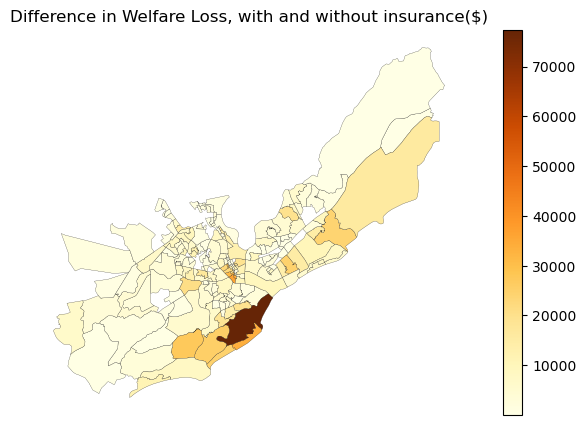

In [43]:
f, ax = plt.subplots(figsize=(10, 5))
bg_no_insurance.plot(ax=ax, column='diff_welfare_loss', categorical=False, 
                     linewidth=0.15, edgecolor='k', cmap='YlOrBr', legend=True)#, scheme='quantiles', k=12)
bg_no_insurance.plot(ax=ax, column='welfare_no_damage',cmap='Greys', categorical=False, linewidth=0.15, edgecolor='k')

ax.set_title('Difference in Welfare Loss, with and without insurance($)')
ax.set_aspect(1.2) 
ax.axis('off')
legend = ax.get_legend()
        
if save_figures:
    f.savefig(f'{folder}/map, difference_in_welfare_loss insurance.jpg', dpi=1000, bbox_inches='tight')

In [44]:
bg_no_insurance['index_number'] = bg_no_insurance.index
high_income_data = bg_no_insurance[bg_no_insurance['Income_Category'] == 'low_incomes']

bg_no_insurance.explore(column='welfare_loss',cmap='YlOrBr',style_kwds=dict(color="black"), tooltip=["index_number",'welfare_loss', 'v', 'ave_i_0','Income_Category','recovery_time','fract_prem_i_0'])

In [45]:
min_value = min(bg_no_insurance['welfare_loss'].min(), bg_no_insurance['ave_damage'].min())
max_value = max(bg_no_insurance['welfare_loss'].max(), bg_no_insurance['ave_damage'].max())
# bg_base_insurance.explore(column='welfare_loss', cmap='YlOrBr', style_kwds=dict(color="black"), tooltip=["index_number",'welfare_loss', 'v', 'ave_i_0','Income_Category','recovery_time','fract_prem_i_0'], vmin=min_value, vmax=max_value)

bg_no_insurance.explore(column='welfare_loss', cmap='YlOrBr', style_kwds=dict(color="black"), tooltip=["index_number",'welfare_loss', 'v', 'ave_i_0','Income_Category','recovery_time','fract_prem_i_0'], vmin=min_value, vmax=max_value)

#### map recovery time insurance & recovery time without insurance

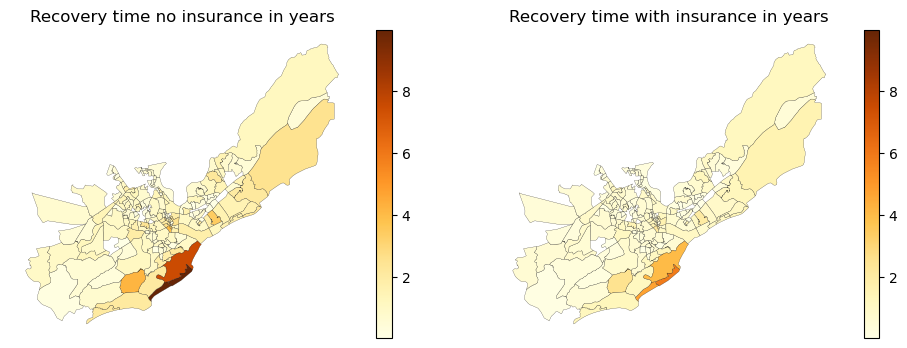

In [46]:
min_value = min(bg_base_insurance['recovery_time'].min(), bg_no_insurance['recovery_time'].min())
max_value = max(bg_base_insurance['recovery_time'].max(), bg_no_insurance['recovery_time'].max())

f, ax = plt.subplots(1, 2, figsize=(12, 4))
f.subplots_adjust(wspace=0.1)  # Adjust the width space between subplots

bg_no_insurance.plot(ax=ax[0], column='recovery_time', categorical=False, 
                    linewidth=0.15, edgecolor='k', cmap='YlOrBr', legend=True, vmin=min_value, vmax=max_value)
bg_no_insurance.plot(ax=ax[0], column='welfare_no_damage',cmap='Greys', categorical=False, linewidth=0.15, edgecolor='k')
bg_base_insurance.plot(ax=ax[1], column='recovery_time', categorical=False, 
                    linewidth=0.15, edgecolor='k', cmap='YlOrBr', legend=True, vmin=min_value, vmax=max_value)
bg_no_insurance.plot(ax=ax[1], column='welfare_no_damage',cmap='Greys', categorical=False, linewidth=0.15, edgecolor='k')

ax[0].set_title('Recovery time no insurance in years')
ax[1].set_title('Recovery time with insurance in years')

for axis in ax:
    axis.set_aspect(1.2) 
    
ax[0].axis('off')
ax[1].axis('off')

if save_figures == True:
    f.savefig(f'{folder}/maps, extreme event, recovery time with and without insurance.jpg', dpi=1000, bbox_inches='tight')

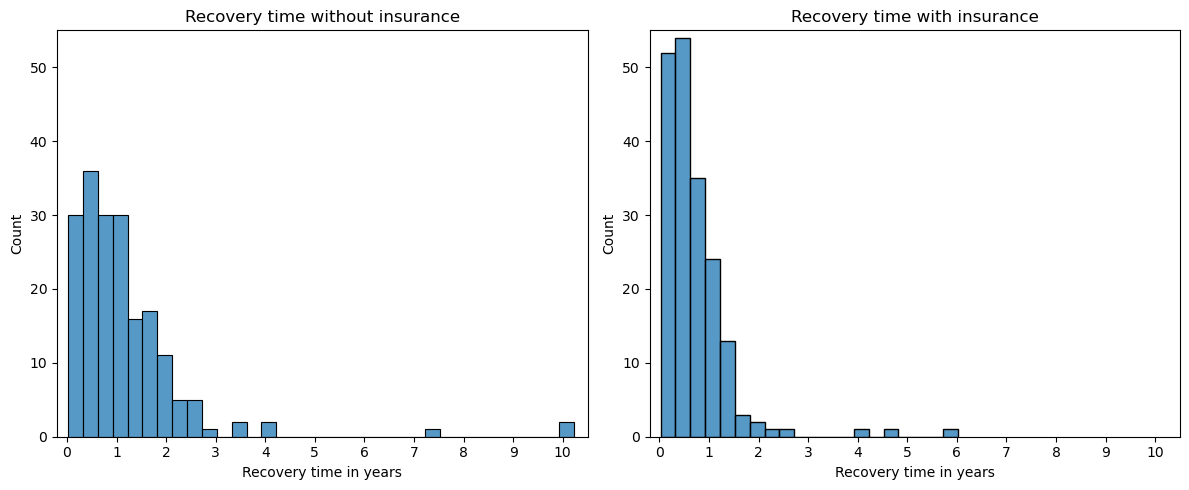

In [47]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

sns.histplot(data=bg_no_insurance['recovery_time'], ax=axs[0], binwidth=0.3)
axs[0].set_title('Recovery time without insurance')

sns.histplot(data=bg_base_insurance['recovery_time'], ax=axs[1],binwidth=0.3)
axs[1].set_title('Recovery time with insurance')

for ax in axs:
    ax.set_xlabel('Recovery time in years')
    ax.set_xlim(-0.2, 10.5)
    ax.set_ylim(0, 55)
    ax.set_xticks(np.arange(0, 11, 1))  # Set x-axis ticks from 0 to 10 with step size 1
    ax.set_xticklabels(np.arange(0, 11, 1))

plt.tight_layout()
if save_figures == True:
    plt.savefig(f'{folder}/histogram, insurance, recovery time.jpg', dpi=300, bbox_inches='tight')

In [48]:
bg_no_insurance['take_up'] = bg_no_insurance.apply(lambda row: True if row['fract_prem_i_0'] < 7.5 else False, axis=1)

In [49]:
bg_no_insurance['premium_true'] = bg_no_insurance['premium'].where(bg_no_insurance['take_up'])
bg_no_insurance['frac_premium_true'] = bg_no_insurance['fract_prem_i_0'].where(bg_no_insurance['take_up'])

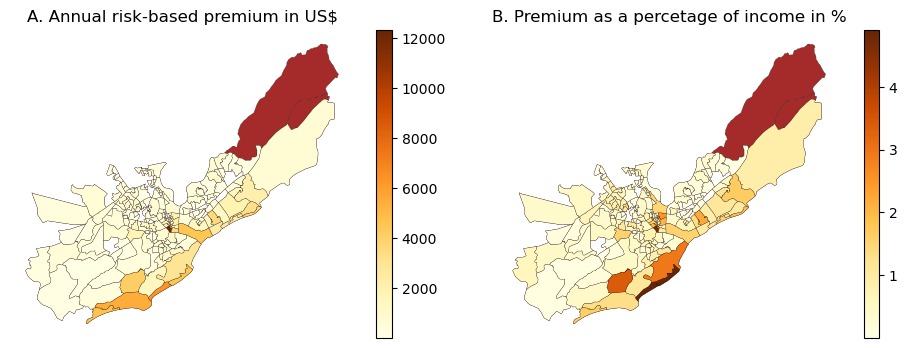

In [50]:
f, ax = plt.subplots(1, 2, figsize=(12, 4))
f.subplots_adjust(wspace=0.1)  # Adjust the width space between subplots

bg_no_insurance.plot(ax=ax[0], color='brown', categorical=False, linewidth=0.15, edgecolor='k')
bg_no_insurance.plot(ax=ax[0], column='premium_true', categorical=False, 
                    linewidth=0.15, edgecolor='k', cmap='YlOrBr', legend=True)#, scheme='QUANTILES', k=10)

bg_no_insurance.plot(ax=ax[1], color='brown', categorical=False, linewidth=0.15, edgecolor='k')
bg_no_insurance.plot(ax=ax[1], column='frac_premium_true', categorical=False, 
                    linewidth=0.15, edgecolor='k', cmap='YlOrBr', legend=True)#, scheme='QUANTILES', k=10)

ax[0].set_title('A. Annual risk-based premium in US$')
ax[1].set_title('B. Premium as a percetage of income in %')

for axis in ax:
    axis.set_aspect(1.2) 
    
ax[0].axis('off')
ax[1].axis('off')

if save_figures == True:
    f.savefig(f'{folder}/maps, premiums.jpg', dpi=1000, bbox_inches='tight')

#### map premiums & map premiums as a fraction of income

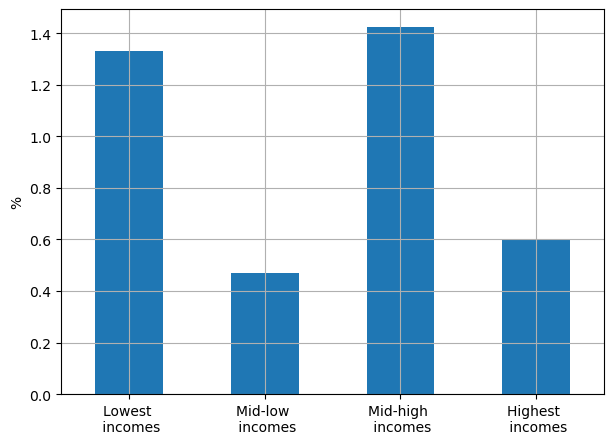

In [51]:
fig, ax = plt.subplots()
bar_width = 0.2
data_quantiles_base_insurance['frac_premium'].plot(figsize=(7, 5),kind='bar', stacked=False, ax=ax)
ax.set_ylabel('%')
ax.set_xlabel('')
# ax.set_title('Premium as a Percentage of Income')
ax.grid(True) 
ax.set_xticklabels(['Lowest \n incomes', 'Mid-low \n incomes', 'Mid-high \n incomes', 'Highest \n incomes'], rotation=0)
if save_figures == True:
    plt.savefig(f'{folder}/quantiles, frac_premium.jpg', dpi=500, bbox_inches='tight')
plt.show()

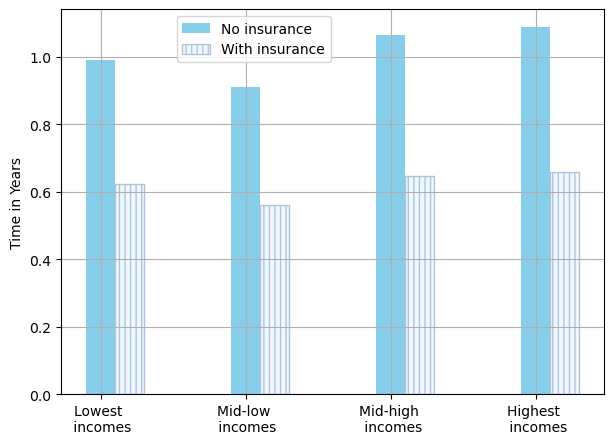

In [52]:
fig, ax = plt.subplots(figsize=(7, 5))
bar_width = 0.2
ax = data_quantiles_no_insurance['recovery_time'].plot(kind='bar', color='skyblue',stacked=False, position=0.5,ax=ax, width=bar_width)
data_quantiles_base_insurance['recovery_time'].plot(hatch='|||',edgecolor='lightsteelblue',kind="bar",color='aliceblue', ax=ax, stacked=False, position=-0.5, width=bar_width)

ax.set_ylabel('Time in Years')
ax.set_xlabel('')
# ax.set_title('Optimal Recovery Time in Years')
ax.grid(True) 
ax.set_xticklabels(categories, rotation=0)
ax.legend(bbox_to_anchor=(0.2, 1), loc='upper left',labels=['No insurance', 'With insurance', 'uptake 65% insurance', 'uptake 80% insurance'])
plt.axis('tight')

if save_figures == True:
    plt.savefig(f'{folder}/quantiles, reovery_time, insurance.jpg', dpi=500, bbox_inches='tight')

plt.show()

#### results per income group → premium as a fraction of income (???)

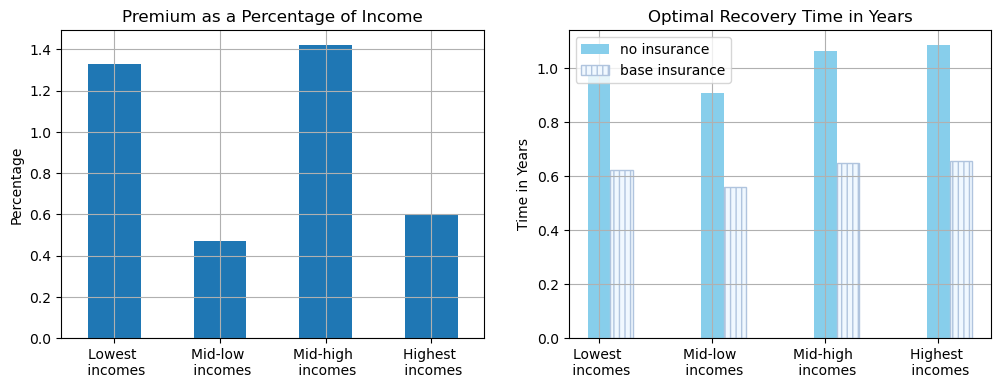

In [53]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))
bar_width = 0.2
ax = data_quantiles_base_insurance['frac_premium'].plot(kind='bar', stacked=False, ax=axs[0])
ax.set_ylabel('Percentage')
ax.set_xlabel('')
ax.set_title('Premium as a Percentage of Income')
ax.grid(True) 
ax.set_xticklabels(categories, rotation=0)

ax = data_quantiles_no_insurance['recovery_time'].plot(kind='bar', color='skyblue',stacked=False, position=0.5,ax=axs[1], width=bar_width)
data_quantiles_base_insurance['recovery_time'].plot(hatch='|||',edgecolor='lightsteelblue',kind="bar",color='aliceblue', ax=axs[1], stacked=False, position=-0.5, width=bar_width)

ax.set_ylabel('Time in Years')
ax.set_xlabel('')
ax.set_title('Optimal Recovery Time in Years')
ax.grid(True) 
ax.set_xticklabels(categories, rotation=0)
ax.legend(['no insurance', 'base insurance', 'uptake 65% insurance', 'uptake 80% insurance'])

plt.axis('tight')

if save_figures == True:
    plt.savefig(f'{folder}/quantiles, frac_premium and reovery_time.jpg', dpi=500, bbox_inches='tight')

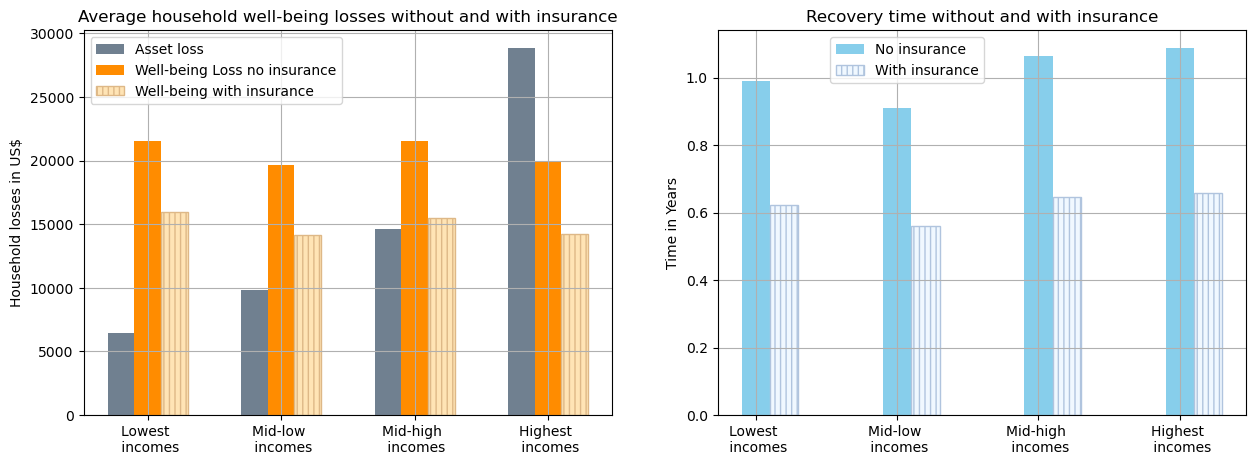

In [54]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
colors = ['slategray', 'darkorange', 'moccasin', 'linen', 'yellowgreen', 'khaki']
# Plotting the first graph
ax = data_quantiles_no_insurance['damage'].plot(ax=axs[0], kind='bar', stacked=False, position=1.5, color=colors[0], width=bar_width)
data_quantiles_no_insurance['welfare_loss'].plot(ax=ax, kind="bar", stacked=False, position=0.5, color=colors[1], width=bar_width)
data_quantiles_base_insurance['welfare_loss'].plot(hatch='|||',edgecolor='burlywood',kind="bar", ax=ax, stacked=False, position=-0.5, color=colors[2], width=bar_width)
ax.set_ylabel('Household losses in US$')
ax.set_xlabel('')
ax.set_title(f'Average household well-being losses without and with insurance')
ax.grid(True)
ax.set_xticklabels(['Lowest \n incomes', 'Mid-low \n incomes', 'Mid-high \n incomes', 'Highest \n incomes'], rotation=0)
ax.legend(['Asset loss', 'Well-being Loss no insurance', 'Well-being with insurance', 'Welfare Loss with insurance 65% take up', 'Welfare Loss with insurance 80% take up'])
ax.axis('tight')
# Plotting the second graph
ax = data_quantiles_no_insurance['recovery_time'].plot(ax=axs[1], kind='bar', color='skyblue', stacked=False, position=0.5, width=bar_width)
data_quantiles_base_insurance['recovery_time'].plot(ax=ax, hatch='|||', edgecolor='lightsteelblue', kind="bar", color='aliceblue', stacked=False, position=-0.5, width=bar_width)
ax.set_ylabel('Time in Years')
ax.set_xlabel('')
ax.set_title(f'Recovery time without and with insurance')
ax.grid(True) 
ax.set_xticklabels(['Lowest \n incomes', 'Mid-low \n incomes', 'Mid-high \n incomes', 'Highest \n incomes'], rotation=0)
ax.legend(bbox_to_anchor=(0.2, 1), loc='upper left',labels=['No insurance', 'With insurance', 'uptake 65% insurance', 'uptake 80% insurance'])

plt.axis('tight')

if save_figures == True:
    plt.savefig(f'{folder}/Quantiles, insurance, well-being and recovery time.jpg', dpi=500, bbox_inches='tight')

plt.show()


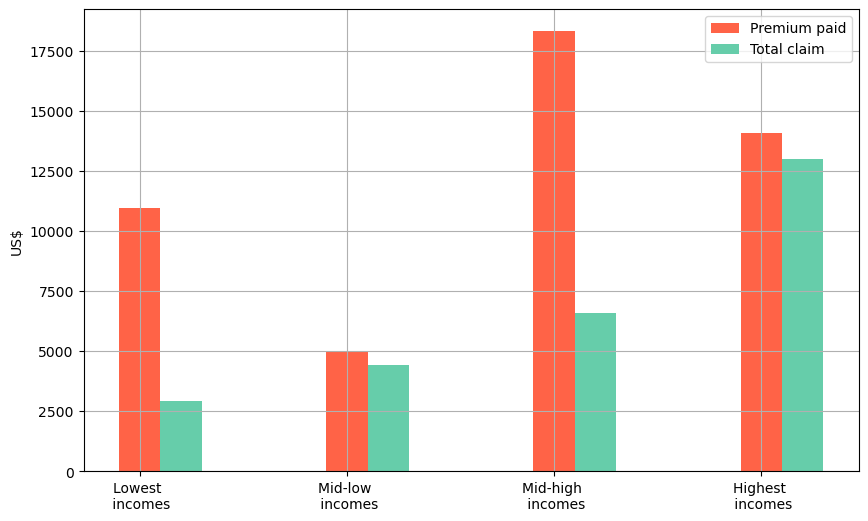

In [55]:
fig, axs = plt.subplots(1, 1, figsize=(10, 6))  # Modify figsize accordingly
bar_width = 0.2  # Adjust bar width if needed

ax = premium_df['total_premium_payed'].plot(kind='bar', color='tomato',position=0.5, ax=axs, width=bar_width)
premium_df['total_claim'].plot(kind='bar', color='mediumaquamarine',position=-0.5, ax=axs, width=bar_width)

ax.set_ylabel('US$')
ax.set_xlabel('')
# ax.set_title('Premium paid versus payout received')
ax.grid(True)
ax.set_xticklabels(['Lowest \n incomes', 'Mid-low \n incomes', 'Mid-high \n incomes', 'Highest \n incomes'], rotation=0)

ax.legend(['Premium paid', 'Total claim'])

plt.axis('tight')

if save_figures == True:
    plt.savefig(f'{folder}/quantiles, premium paid versus total claim.jpg', dpi=500, bbox_inches='tight')

#### results per income group → damage & welfare loss with insurance & welfare loss without insurance & third scenario (???)

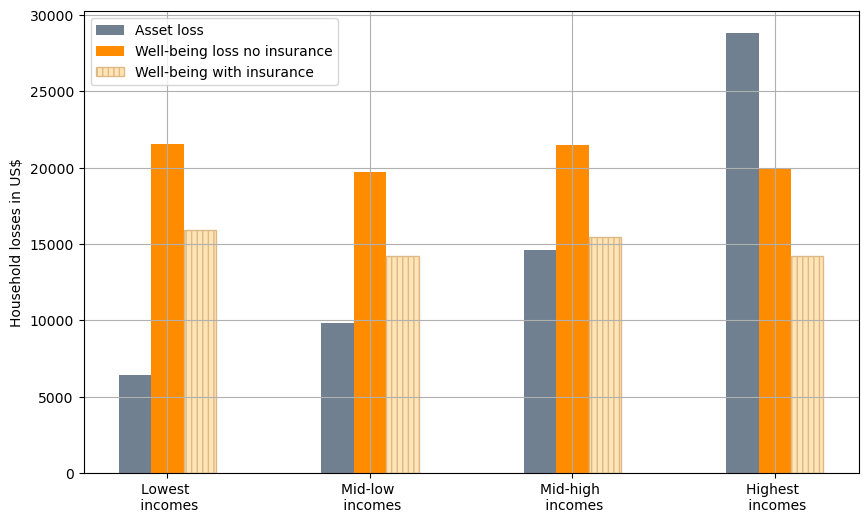

In [56]:
bar_width=0.16

colors = ['slategray', 'darkorange', 'moccasin', 'linen', 'yellowgreen', 'khaki']
custom_cmap = ListedColormap(colors)

ax = data_quantiles_no_insurance['damage'].plot(figsize=[10,6],kind='bar', stacked=False, position=1.5, color=colors[0],width=bar_width)
data_quantiles_no_insurance['welfare_loss'].plot(kind="bar", ax=ax, stacked=False, position=0.5, color=colors[1], width=bar_width)
data_quantiles_base_insurance['welfare_loss'].plot(hatch='|||',edgecolor='burlywood',kind="bar", ax=ax, stacked=False, position=-0.5, color=colors[2], width=bar_width)
# data_quantiles_uptake65_insurance['welfare_loss'].plot(hatch='|||',edgecolor='bisque',kind="bar", ax=ax, stacked=False, position=-1.5, color=colors[3], width=bar_width)
# data_quantiles_uptake80_insurance['welfare_loss'].plot(kind="bar", ax=ax, stacked=False, position=-2.5, color='beige', width=bar_width)

#INCLUDE INCOME LOSS
# ax = data_quantiles_no_insurance['damage'].plot(figsize=[10,6],kind='bar', stacked=False, position=2.7, color=colors[0],width=bar_width)
# data_quantiles_no_insurance['welfare_loss'].plot(kind="bar", ax=ax, stacked=False, position=1.5, color=colors[1], width=bar_width)
# data_quantiles_base_insurance['welfare_loss'].plot(hatch='|||',edgecolor='burlywood',kind='bar',ax=ax, stacked=False, position=0.5, color=colors[2],width=bar_width)
# # data_quantiles_uptake65_insurance['welfare_loss'].plot(kind="bar", ax=ax, stacked=False, position=-1.5, color=colors[3], width=bar_width)

# data_quantiles_no_insurance['income_loss'].plot(kind="bar", ax=ax, stacked=False, position=-0.7, color=colors[4], width=bar_width)
# data_quantiles_base_insurance['income_loss'].plot(hatch='|||',edgecolor='darkkhaki',kind="bar", ax=ax, stacked=False, position=-1.7, color=colors[5], width=bar_width)

ax.set_ylabel('Household losses in US$')
ax.set_xlabel('')
# ax.set_title(f'Damage and Welfare Loss Quantiles')
ax.grid(True)
plt.axis('tight')  # Adjust layout to reduce whitespace
# ax.set_ylim(0, 27000)

categories = ['Lowest \n incomes', 'Mid-low \n incomes', 'Mid-high \n incomes', 'Highest \n incomes']
plt.xticks(range(len(categories)), categories, rotation=0)

# Display the legend
ax.legend(['Asset loss', 'Well-being loss no insurance', 'Well-being with insurance', 'Welfare Loss with insurance 65% take up', 'Welfare Loss with insurance 80% take up'])

if save_figures == True:
    plt.savefig(f'{folder}/Quantiles, well-being loss, insurance scenarios.jpg',dpi=500, bbox_inches='tight')

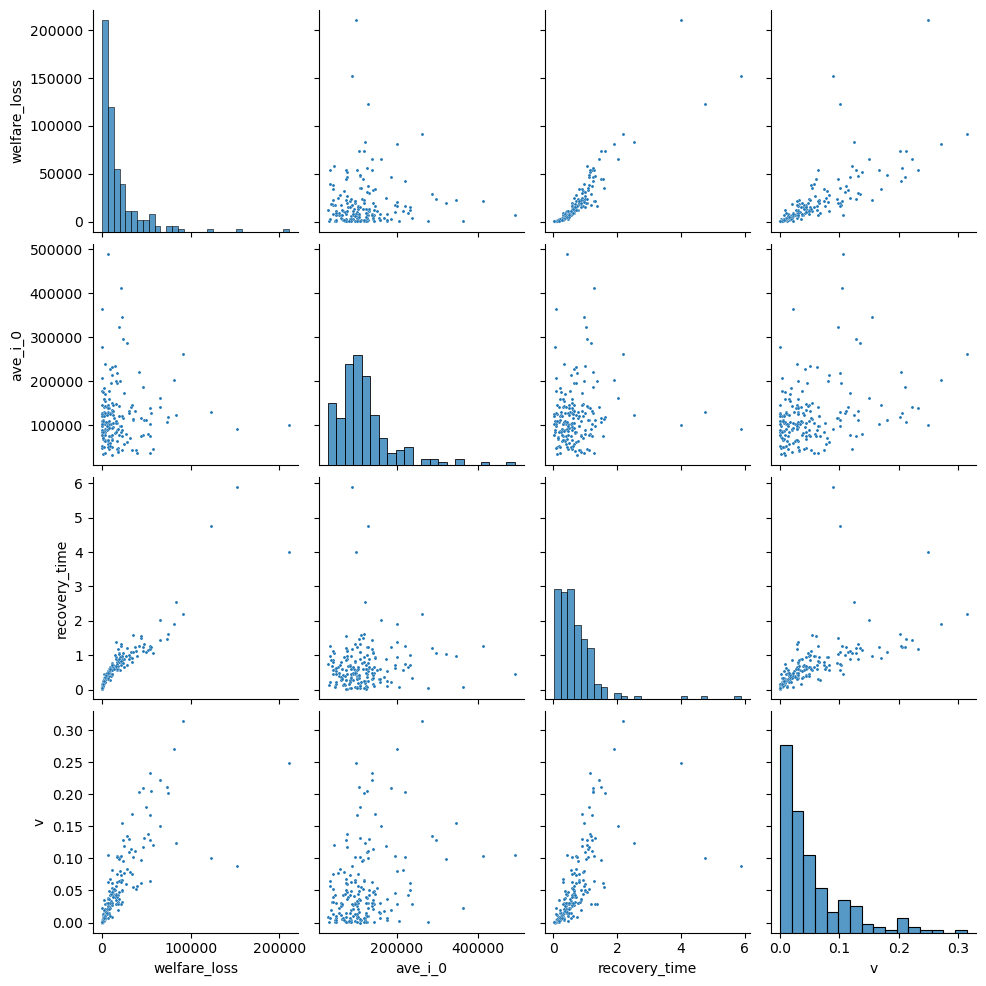

In [57]:
columns_of_interest = ['welfare_loss', 'ave_i_0', 'recovery_time', 'v']
subset_df = bg_base_insurance[columns_of_interest]
sns.pairplot(subset_df, plot_kws={'s': 5})